In [1]:
import pickle, os, re, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, auc, precision_recall_curve, roc_curve


In [2]:
# Speeds : "slow" / "normal" / "fast"
SPEED = "normal"

remove_speed_correlated_features = True

## STEP 1: Load 1849 OA and Control walking data and metadata separately.

In [3]:
#load data
subjects_all = []
data_all = {}

clinicalFeatures = pd.read_csv("data/Moticon/digital_insole_OA_summary_parameters.csv", index_col=0)
datatmp = clinicalFeatures

subgeneral = []
for x in datatmp.index:
    tmp = re.sub('digital_insole_OA_', 'OA', x).split("_D")
    subgeneral.append(tmp[0])
datatmp['subjects'] = subgeneral
data1849 = datatmp.set_index('subjects')

data1849.fillna(datatmp.mean(numeric_only = True),inplace=True)
    


In [4]:
pilotFeatures = pd.read_csv("data/Moticon/digital_insole_HC_summary_parameters.csv", index_col=0)
datatmp = pilotFeatures
datatmp = datatmp[datatmp["speed"] == SPEED].drop(columns = ['speed'])

subgeneral = []
for x in datatmp.index:
    tmp = re.sub('digital_insole_HC_', 'HC', x).split("_")
    subgeneral.append(tmp[0])
datatmp['subjects'] = subgeneral
dataHC = datatmp.set_index('subjects')

dataHC.fillna(datatmp.mean(numeric_only=True),inplace=True)


In [5]:
data_all = pd.concat([data1849, dataHC])

if remove_speed_correlated_features:
    speed_correlated_features = list(pd.read_csv("data/Moticon/speed_correlated_features.txt", header = None)[0])
    remove_features = speed_correlated_features + ['walking_distance(m)', 'COP trace length (right) (m)', 'COP trace length (left) (m)'] #walking distance is an obvious linear separator based on study designs. Discard
    keep_features = [x for x in data_all.columns if x not in remove_features]

    data_all = data_all[keep_features] #combine 1849 and REGN data into one dataframe

#print some stats about the dataset
print("Total Healthy Control Observations (walks):", len(dataHC.index))
print("Number of Unique Healthy Control Subjects:", len(set(dataHC.index)))
print("Total Osteo-Arthritis Clinical Observations (walks):", len(data1849.index))
print("Number of Unique Osteo-Arthritis Clinical Subjects:",len(set(data1849.index)))


Total Healthy Control Observations (walks): 243
Number of Unique Healthy Control Subjects: 21
Total Osteo-Arthritis Clinical Observations (walks): 73
Number of Unique Osteo-Arthritis Clinical Subjects: 37


## STEP 2: Start modeling with leave-subject-out approach

In [48]:
#################################################################

subject_classification_results = {} #stores metrics for each left-out subject
y_prob = [] #store all predictions
y_pred = [] #store all predictions
y_target = [] #store all target labels
allsub = np.unique(data_all.index) #np.unique() because we want to leave out the entire subject, not just the individual walks
for left_out in allsub: #each for loop leaves a different subject out and creates a new model
    data_all_copy = copy.deepcopy(data_all)
    data_all_copy = data_all_copy

#################################################################
#STEP 2.1: Create test/train x and y data
    print("Leaving out subject:", left_out)#don't change data_all
    X_train = data_all_copy.drop(left_out)
    ytmp = []
    for walk in X_train.index:
        if "HC" in walk: 
            ytmp.append(0)
        elif "OA" in walk:
            ytmp.append(1)
    y_train = np.array(ytmp)
    
    X_test = data_all_copy.loc[left_out,:]
    numTestSamples = len([x for x in data_all_copy.index if left_out in x])
    X_test = X_test.values.reshape(numTestSamples,-1)
    y_test = np.array([])
    ytmp = []

    if "HC" in left_out: 
        y_test = np.array([0]*numTestSamples)
    elif "OA" in left_out:
        y_test = np.array([1]*numTestSamples)
        
#################################################################
#STEP 2.2: Scale the data, fit to model, and predict on test set
    metrics = {} #holds any metrics you want for the left-out subject. resets for each new subject
        
    scaler = preprocessing.StandardScaler().fit(X_train)

    X_train_transformed = scaler.transform(X_train)
    X_test_transformed = scaler.transform(X_test)
    model = XGBClassifier(eval_metric='mlogloss')

    model.fit(X_train_transformed, y_train)
    
    # evaluate model
    yhat = model.predict(X_test_transformed)
    probs = [x[1] for x in model.predict_proba(X_test_transformed)]
    
    # calculate metrics
    acc = accuracy_score(y_test, yhat)

    # Store predictions/metrics
    y_prob.extend(probs)
    y_pred.extend(yhat)
    y_target.extend(y_test)
    metrics["Accuracy"] = acc

    subject_classification_results[left_out] = metrics #save results for left-out subject
    print("Classification for Subject " + left_out + ": Accuracy = " + str(acc) )

Leaving out subject: HC01
Classification for Subject HC01: Accuracy = 1.0
Leaving out subject: HC02
Classification for Subject HC02: Accuracy = 1.0
Leaving out subject: HC03
Classification for Subject HC03: Accuracy = 1.0
Leaving out subject: HC04
Classification for Subject HC04: Accuracy = 1.0
Leaving out subject: HC05
Classification for Subject HC05: Accuracy = 1.0
Leaving out subject: HC06


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject HC06: Accuracy = 1.0
Leaving out subject: HC07
Classification for Subject HC07: Accuracy = 1.0
Leaving out subject: HC08
Classification for Subject HC08: Accuracy = 1.0
Leaving out subject: HC09
Classification for Subject HC09: Accuracy = 1.0
Leaving out subject: HC10
Classification for Subject HC10: Accuracy = 0.9166666666666666
Leaving out subject: HC11
Classification for Subject HC11: Accuracy = 1.0
Leaving out subject: HC12


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject HC12: Accuracy = 1.0
Leaving out subject: HC13
Classification for Subject HC13: Accuracy = 1.0
Leaving out subject: HC14
Classification for Subject HC14: Accuracy = 1.0
Leaving out subject: HC15
Classification for Subject HC15: Accuracy = 1.0
Leaving out subject: HC16
Classification for Subject HC16: Accuracy = 1.0
Leaving out subject: HC17
Classification for Subject HC17: Accuracy = 0.9090909090909091
Leaving out subject: HC18


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject HC18: Accuracy = 1.0
Leaving out subject: HC19
Classification for Subject HC19: Accuracy = 1.0
Leaving out subject: HC20
Classification for Subject HC20: Accuracy = 1.0
Leaving out subject: HC21
Classification for Subject HC21: Accuracy = 1.0
Leaving out subject: OA01
Classification for Subject OA01: Accuracy = 1.0
Leaving out subject: OA02


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Classification for Subject OA02: Accuracy = 1.0
Leaving out subject: OA03
Classification for Subject OA03: Accuracy = 1.0
Leaving out subject: OA04
Classification for Subject OA04: Accuracy = 1.0
Leaving out subject: OA05
Classification for Subject OA05: Accuracy = 1.0
Leaving out subject: OA06
Classification for Subject OA06: Accuracy = 1.0
Leaving out subject: OA07
Classification for Subject OA07: Accuracy = 1.0
Leaving out subject: OA08


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject OA08: Accuracy = 1.0
Leaving out subject: OA09
Classification for Subject OA09: Accuracy = 0.5
Leaving out subject: OA10
Classification for Subject OA10: Accuracy = 1.0
Leaving out subject: OA11
Classification for Subject OA11: Accuracy = 1.0
Leaving out subject: OA12
Classification for Subject OA12: Accuracy = 1.0
Leaving out subject: OA13
Classification for Subject OA13: Accuracy = 1.0
Leaving out subject: OA14


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject OA14: Accuracy = 1.0
Leaving out subject: OA15
Classification for Subject OA15: Accuracy = 1.0
Leaving out subject: OA16
Classification for Subject OA16: Accuracy = 1.0
Leaving out subject: OA17
Classification for Subject OA17: Accuracy = 1.0
Leaving out subject: OA18
Classification for Subject OA18: Accuracy = 1.0
Leaving out subject: OA19
Classification for Subject OA19: Accuracy = 1.0
Leaving out subject: OA20


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject OA20: Accuracy = 1.0
Leaving out subject: OA21
Classification for Subject OA21: Accuracy = 1.0
Leaving out subject: OA22
Classification for Subject OA22: Accuracy = 0.5
Leaving out subject: OA23
Classification for Subject OA23: Accuracy = 1.0
Leaving out subject: OA24
Classification for Subject OA24: Accuracy = 1.0
Leaving out subject: OA25
Classification for Subject OA25: Accuracy = 1.0
Leaving out subject: OA26


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject OA26: Accuracy = 0.5
Leaving out subject: OA27
Classification for Subject OA27: Accuracy = 1.0
Leaving out subject: OA28
Classification for Subject OA28: Accuracy = 1.0
Leaving out subject: OA29
Classification for Subject OA29: Accuracy = 1.0
Leaving out subject: OA30
Classification for Subject OA30: Accuracy = 1.0
Leaving out subject: OA31
Classification for Subject OA31: Accuracy = 1.0
Leaving out subject: OA32


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/User

Classification for Subject OA32: Accuracy = 1.0
Leaving out subject: OA33
Classification for Subject OA33: Accuracy = 1.0
Leaving out subject: OA34
Classification for Subject OA34: Accuracy = 0.5
Leaving out subject: OA35
Classification for Subject OA35: Accuracy = 1.0
Leaving out subject: OA36
Classification for Subject OA36: Accuracy = 1.0
Leaving out subject: OA37
Classification for Subject OA37: Accuracy = 1.0


/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/kaitlyn.gayvert/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


normal: speed correlated features removed

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       243
           1       0.97      0.95      0.96        73

    accuracy                           0.98       316
   macro avg       0.98      0.97      0.97       316
weighted avg       0.98      0.98      0.98       316

auROC score: 0.9979
auPR score: 0.9932


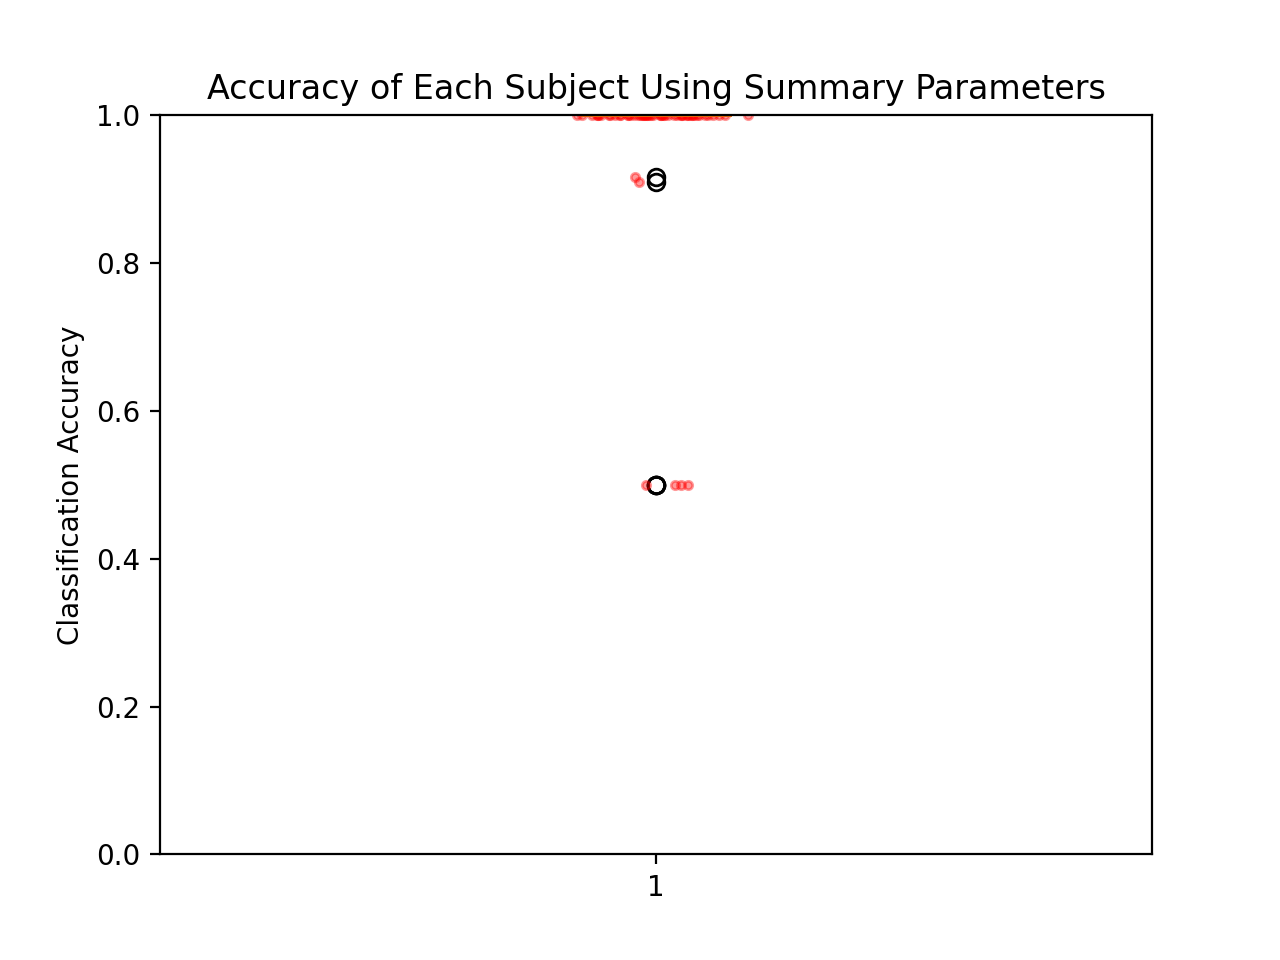

In [53]:
if remove_speed_correlated_features:
    print(SPEED + ": speed correlated features removed\n")
else:
    print(SPEED + ": speed correlated features included\n")


#################################################################
#STEP 3: Plot the accuracy results for each left out subject with a boxplot
val = []
for idx, k in enumerate(subject_classification_results.keys()):
    val.append(subject_classification_results[k]['Accuracy'])
print(classification_report(y_target, y_pred))
    #plot boxplot of subject accuracies

moticon_fpr, moticon_tpr, thresholds = roc_curve(y_target, y_prob)
print('\033[1mauROC score: {0:.4f}'.format(roc_auc_score(y_target, y_prob)))
moticon_precision, moticon_recall, thresholds = precision_recall_curve(y_target, y_prob)
print('\033[1mauPR score: {0:.4f}'.format(auc(moticon_recall, moticon_precision)))
    
plt.figure()
numBoxes = 1
data = val
bp = plt.boxplot(data)
plt.ylim([0,1])
plt.ylabel("Classification Accuracy")
plt.title("Accuracy of Each Subject Using Summary Parameters")
y = data
x = np.random.normal(1, 0.03, size=len(data))
plt.plot(x, y, 'r.', alpha=0.4)
plt.show() 

## Feature Importance

In [38]:
imp = pd.DataFrame({"features":data_all.columns,"importance":model.feature_importances_})
imp[imp["importance"] != 0].sort_values("importance", ascending = False).head(5)

,features,importance
63,Mean COP velocity (right) (mm/s),0.362323
39,Standard deviation x of gait line startpoint (...,0.109475
43,Standard deviation y of gait line startpoint (...,0.094259
38,Standard deviation x of gait line startpoint (...,0.075833
0,Force raise (left) (s),0.070618


## Plot Results

In [50]:
from plotnine import ggplot, geom_line, scale_color_manual, theme_bw, geom_abline, xlab, geom_hline, aes, ylim


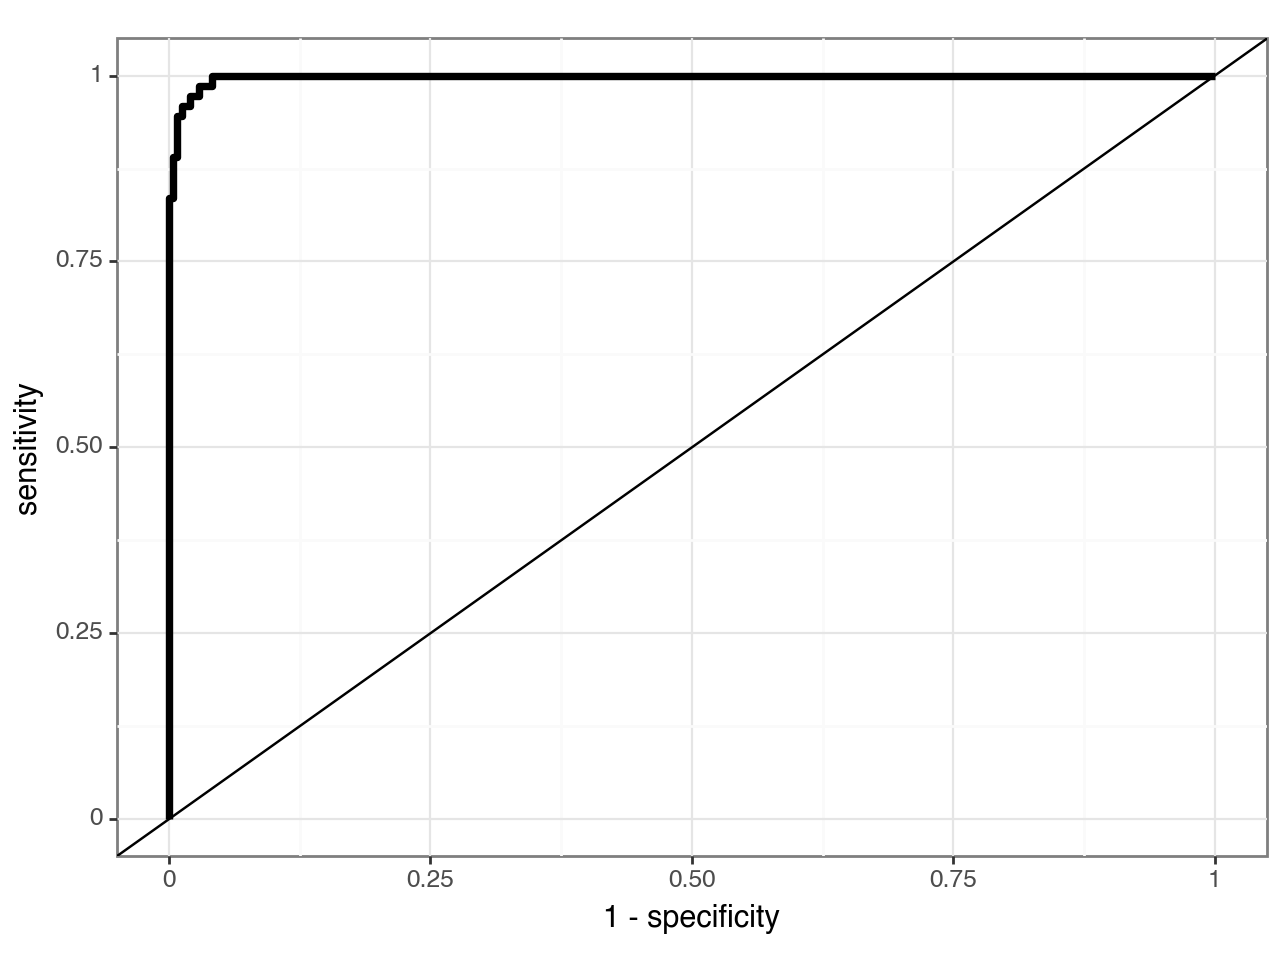

In [51]:
roc_data = pd.concat([
    pd.DataFrame({'fpr' : moticon_fpr, 'sensitivity' : moticon_tpr, 'dataset' : 'Wearable Digital Insole\nTest Set'})
])

print(
    ggplot(roc_data, aes(x = "fpr", y= "sensitivity"))
    + geom_line(size = 1.5)
    + theme_bw()
    + geom_abline(intercept = 0, slope = 1)
    + xlab('1 - specificity')
)


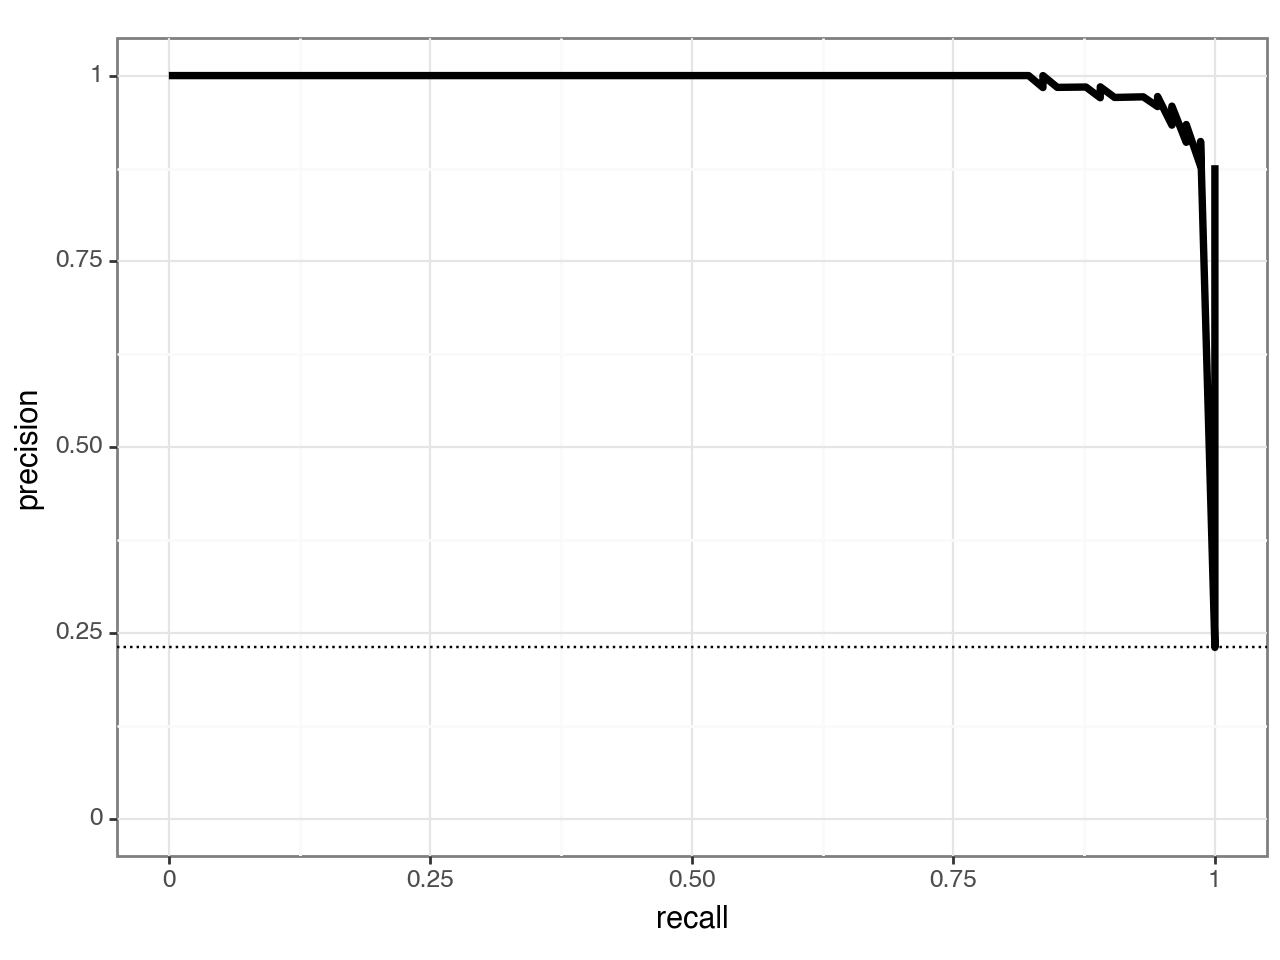

In [52]:
pr_data = pd.concat([
    pd.DataFrame({'precision' : moticon_precision, 'recall' : moticon_recall, 'dataset' : 'Wearable Digital Insole\nTest Set'})
])

print(
    ggplot(pr_data, aes(x = "recall", y= "precision"))
    + geom_line(size = 1.5)
    + theme_bw()
    + ylim(0,1)
    + geom_hline(yintercept =  sum(y_target) / len(y_target), linetype = "dotted")
)
